# Evaluation

This notebook contains the code the reproduce Table 1-3 and Figure 2 from the paper. 

In [5]:
from tqdm.notebook import tqdm
import json
import pandas as pd
import numpy as np
import pickle
from smart_open import open
import os
import random
import json
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from IPython.core.display import display
from collections import defaultdict
import itertools
from experiments.evaluation.utils import highlight_max

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

2020-11-15 21:45:53 - INFO - nlp.utils.file_utils -   PyTorch version 1.4.0 available.
2020-11-15 21:45:53 - INFO - nlp.utils.file_utils -   TensorFlow version 2.3.1 available.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [12]:
aspects = ['task', 'method', 'dataset']
folds = [1, 2, 3, 4]
df = pd.read_csv(f'./output/pwc/reeval.csv', index_col=False)
df.head()

,name,aspect,fold,top_k,retrieved_docs,relevant_docs,relevant_retrieved_docs,precision,recall,avg_p,reciprocal_rank,ndcg
0,avg_fasttext,task,1,1,1.0,47.047595,0.306873,0.306873,0.013900,0.013900,0.306873,0.306873
1,avg_fasttext,task,1,2,2.0,47.047595,0.562939,0.281469,0.023545,0.021254,0.358822,0.287922
2,avg_fasttext,task,1,3,3.0,47.047595,0.792882,0.264294,0.031658,0.026653,0.378998,0.275111
3,avg_fasttext,task,1,5,5.0,47.047595,1.198242,0.239648,0.045453,0.034533,0.396172,0.257232
4,avg_fasttext,task,1,10,10.0,47.047595,2.046834,0.204683,0.070803,0.046348,0.408631,0.232996


In [3]:
# nice labels
names = {
    # general purpose embeddings
    'avg_fasttext': 'Avg. FastText',
    'specter': 'SPECTER',
    #'scibert_cls': 'SciBERT (CLS)',
    'scibert_mean': 'SciBERT',    
    # retro fitted
    'explirefit_avg_fasttext': 'Retrofitted Avg. FastText',
    'explirefit_specter': 'Retrofitted SPECTER',
    'explirefit_scibert_mean': 'Retrofitted SciBERT',
    
    # fine-tuned transformers
    'specter_fine_tuned': 'Fine-tuned SPECTER',
    'scibert-scivocab-uncased_fine_tuned': 'Fine-tuned SciBERT',
    'st_scibert-scivocab-uncased': 'Sentence-SciBERT',
    #'st_scibert-scivocab-uncased_cosine': 'Sentence-SciBERT (cosine loss)',
}
main_top_k = 10
main_metrics = {
    'precision': 'P', 
    'recall': 'R',
    'reciprocal_rank': 'MRR', 
    'avg_p': 'MAP',
    #'ndcg': 'nDCG',
}

## Table: Overall results

In [6]:
main_df = df[(df['top_k'] == main_top_k) & df.name.isin(names)]
main_df = main_df.groupby(['name','aspect',])[list(main_metrics.keys())].agg('mean').unstack() 
main_df.columns = main_df.columns.swaplevel(0, 1)
main_df = main_df.reindex([(aspect, metric) for aspect in aspects for metric in main_metrics], axis=1)  # column order
main_df = main_df.reindex(names.keys(), axis=0)  # row order
main_df.index = [names[i] for i in main_df.index]  # nice index names
main_df = main_df.rename(columns=main_metrics)  # nice columns
with pd.option_context('precision', 3):
    display(main_df.style.apply(highlight_max))    

## Figure: Performance over k

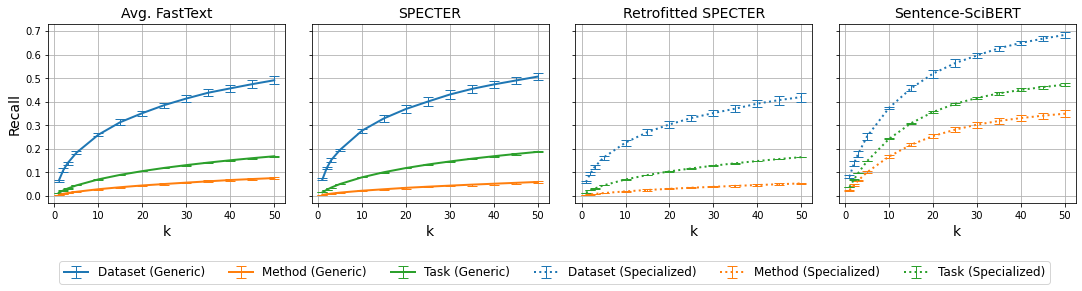

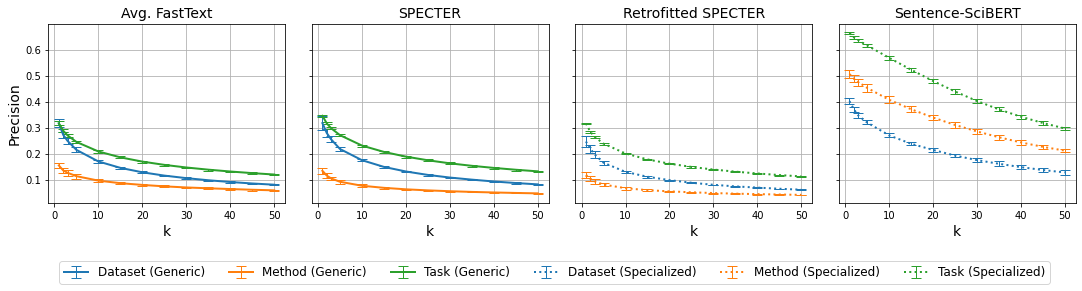

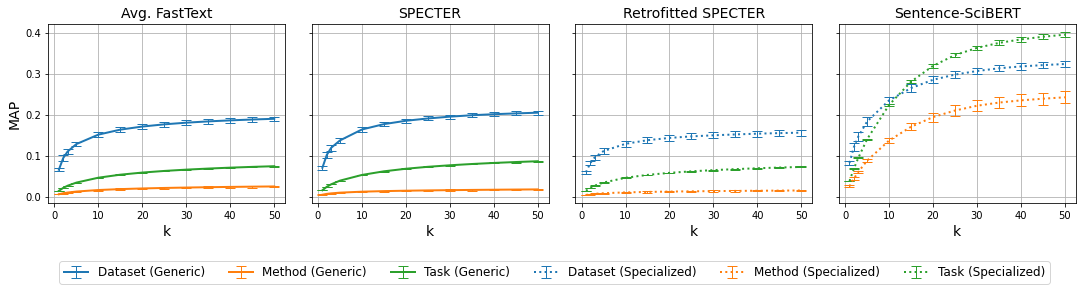

In [9]:
fig_names = [
    'avg_fasttext', 
#    'scibert_mean',
    'specter', 
    'explirefit_specter',
#    'explirefit_avg_fasttext',
    'st_scibert-scivocab-uncased',
]

special_names = [
    'explirefit_specter',
    'explirefit_avg_fasttext',
    'st_scibert-scivocab-uncased',
]
nice_metrics = {
    'avg_p': 'MAP',    
}

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

for metric in ['recall', 'precision', 'avg_p']:
    fig, axs = plt.subplots(nrows=1, ncols=len(fig_names), sharex=True, sharey=True)
    fig.set_figheight(3)
    fig.set_figwidth(15)
    fig.tight_layout() 
    fig.subplots_adjust(bottom=0.1)   ##  Need to play with this number.

    generic_handles = []
    special_handles = []
    generic_labels = []
    special_labels = []

    for name_i, name in enumerate(fig_names):  # fixed sort
        name_df = df[(df.name == name) & (df.top_k <= 50)]
    
        for aspect_i, (aspect, aspect_df) in enumerate(name_df.groupby('aspect')):
            
            xs = []
            ys = []
            yerrs = []
            for top_k, top_k_df in aspect_df.groupby('top_k'):
                xs.append(top_k)
                ys.append(top_k_df[metric].mean())
                yerrs.append(top_k_df[metric].std())
                
            #axs[0, 0] = plt.errorbar(xs, ys, yerr=yerrs, label=names[name], capsize=5)  # , marker='o'
            
            aspect_title = (f'{aspect} (specialized)' if name in special_names else f'{aspect} (generic)').title()
            
            if name in special_names:
                fmt = ':'
            else:
                fmt = '-'
                        
            axs[name_i].errorbar(xs, ys, yerr=yerrs, label=aspect_title, capsize=5, fmt=fmt, linewidth=2, elinewidth=1)            
            axs[name_i].set_xlabel('k', size=BIGGER_SIZE)

        axs[name_i].set_title(names[name], size=BIGGER_SIZE)
        axs[name_i].grid()
        
        handles, labels = axs[name_i].get_legend_handles_labels()
        
        if name in special_names and not special_handles:
            special_handles += handles
            special_labels += labels
        elif not generic_handles:
            generic_handles += handles
            generic_labels += labels
            
    axs[0].set_ylabel(nice_metrics[metric] if metric in nice_metrics else metric.title(), size=BIGGER_SIZE)
    
    fig.legend(generic_handles + special_handles, generic_labels + special_labels, 
               ncol=6, 
               loc='lower center', 
               fontsize=MEDIUM_SIZE,
               bbox_to_anchor=(0.5, -0.3)
              )

    #plt.savefig(f'./figures/{metric}_per_k_systems.pdf', bbox_inches="tight")
    #plt.grid()
    plt.show()
    #break



## Table: Overlap generic vs special

In [17]:
# Load precomputed recommendations (reeval output)
generic_seed_id2ret_docs = json.load(open('./output/pwc/generic_seed_id2ret_docs.json'))
special_seed_id2ret_docs = json.load(open('./output/pwc/special_seed_id2ret_docs.json'))

In [23]:
# count overlap
top_k = 10
generic_names = ['avg_fasttext', 'specter', 'scibert_mean']
special_names = ['explirefit_specter', 'explirefit_avg_fasttext', 'specter_fine_tuned', 'scibert-scivocab-uncased_fine_tuned', 'st_scibert-scivocab-uncased']
rows = []

for aspect in aspects:
    for fold in folds:  
        fold = str(fold)
        for a_name in generic_names + special_names:
            for b_name in generic_names + special_names:
                in_a = 0
                in_b = 0
            
                in_a_and_in_b = 0
                in_a_and_not_in_b = 0
                in_b_and_not_in_a = 0
        
                if a_name in generic_names:
                    a_set = generic_seed_id2ret_docs[aspect][fold][a_name]
                else:    
                    a_set = special_seed_id2ret_docs[aspect][fold][a_name]
                            
                if b_name in generic_names:
                    b_set = generic_seed_id2ret_docs[aspect][fold][b_name]
                else:    
                    b_set = special_seed_id2ret_docs[aspect][fold][b_name]
                    
                for seed_id in a_set:
                    try:
                        a_ret_docs = set(a_set[seed_id][:top_k])
                        b_ret_docs = set(b_set[seed_id][:top_k])
                        in_a += len(a_ret_docs)
                        in_b += len(b_ret_docs)                           
                        in_a_and_in_b += len(a_ret_docs & b_ret_docs)
                        in_a_and_not_in_b += len(a_ret_docs - b_ret_docs)
                        in_b_and_not_in_a += len(b_ret_docs - a_ret_docs)
                        
                    except KeyError:
                        pass
                    
                rows.append((
                    a_name,
                    b_name, 
                    aspect,
                    int(fold),                                    
                    in_a,
                    in_b,
                    in_a_and_in_b / in_a,
                    in_a_and_not_in_b / in_a,
                    in_b_and_not_in_a / in_b,                    
                ))
        
overlap_df = pd.DataFrame(rows, columns=[
    'a_name', 
    'b_name', 
    'aspect', 
    'fold', 
    'in_a', 
    'in_b', 
    'in_a_and_in_b',
    'in_a_and_not_in_b',
    'in_b_and_not_in_a',
])
overlap_df.head()

,a_name,b_name,aspect,fold,in_a,in_b,in_a_and_in_b,in_a_and_not_in_b,in_b_and_not_in_a
0,avg_fasttext,avg_fasttext,task,1,392620,392620,1.000000,0.000000,0.000000
1,avg_fasttext,specter,task,1,392620,392620,0.282884,0.717116,0.717116
2,avg_fasttext,scibert_mean,task,1,392620,392620,0.143948,0.856052,0.856052
3,avg_fasttext,explirefit_specter,task,1,392620,392620,0.215656,0.784344,0.784344
4,avg_fasttext,explirefit_avg_fasttext,task,1,392620,392620,0.681043,0.318957,0.318957


In [24]:
selector = overlap_df.a_name.isin(['specter','avg_fasttext','scibert_mean']) \
    & overlap_df.b_name.isin(['explirefit_avg_fasttext','specter_fine_tuned','st_scibert-scivocab-uncased']) \
    & (overlap_df.a_name != overlap_df.b_name)

replace_with = {
    'avg_fasttext': 'Avg. FastText',
    'explirefit_avg_fasttext': 'Retrofitted Avg. FastText',
    'scibert_mean': 'SciBERT',
    'specter': 'SPECTER',
    'specter_fine_tuned': 'Fine-tuned SPECTER',
    'st_scibert-scivocab-uncased': 'Sent-SciBERT',
    'dataset': 'D',
    'method': 'M',
    'task': 'T',
}

odf = overlap_df[selector]

odf.a_name = [replace_with[n] for n in odf.a_name.values]
odf.b_name = [replace_with[n] for n in odf.b_name.values]
odf.aspect = [replace_with[n] for n in odf.aspect.values]

#odf = odf.groupby(['a_name','b_name', 'aspect'])[['in_a_and_in_b', 'in_b_and_not_in_a']].mean()
odf = odf.groupby(['a_name','b_name', 'aspect'])[['in_b_and_not_in_a']].mean()

# in_b_and_not_in_a
with pd.option_context('precision', 3):
    display(odf)

/home/mostendorff/miniconda2/envs/pairwise-vs-segment/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


in_b_and_not_in_a
a_name        b_name                    aspect                   
Avg. FastText Fine-tuned SPECTER        D                   0.796
                                        M                   0.845
                                        T                   0.816
              Retrofitted Avg. FastText D                   0.394
                                        M                   0.466
                                        T                   0.317
              Sent-SciBERT              D                   0.809
                                        M                   0.952
                                        T                   0.900
SPECTER       Fine-tuned SPECTER        D                   0.768
                                        M                   0.806
                                        T                   0.737
              Retrofitted Avg. FastText D                   0.679
                                        M                   0.754
                                        T                   0.718
              Sent-SciBERT              D                   0.783
                                        M                   0.954
                                        T                   0.883
SciBERT       Fine-tuned SPECTER        D                   0.775
                                        M                   0.817
                                        T                   0.871
              Retrofitted Avg. FastText D                   0.829
                                        M                   0.876
                                        T                   0.866
              Sent-SciBERT              D                   0.908
                                        M                   0.973
                                        T                   0.958

In [ ]:
#with pd.option_context('precision', 3):
#    print(odf.to_latex())

## Table 1: Dataset

In [25]:
from experiments.utils import get_local_hf_dataset_path
from hf_datasets.paperswithcode_aspects import get_train_split, get_test_split
from datasets import load_dataset

aspects = ['task', 'method', 'dataset']

hf_dataset = 'paperswithcode_aspects'
fold = 1

aspect2train_ds = {}
aspect2test_ds = {}


for aspect in aspects:
    aspect2train_ds[aspect] = load_dataset(get_local_hf_dataset_path(hf_dataset),
                       name='relations',
                       cache_dir='./data/nlp_cache',
                       split=get_train_split(aspect, fold))

    aspect2test_ds[aspect] = load_dataset(get_local_hf_dataset_path(hf_dataset),
                       name='relations',
                       cache_dir='./data/nlp_cache',
                       split=get_test_split(aspect, fold))


docs_ds = load_dataset(get_local_hf_dataset_path(hf_dataset),
                   name='docs',
                   cache_dir='./data/nlp_cache',
                      split='docs')

2020-11-15 22:27:41 - INFO - filelock -   Lock 140581998172752 acquired on ./hf_datasets/paperswithcode_aspects/paperswithcode_aspects.py.lock
2020-11-15 22:27:41 - INFO - filelock -   Lock 140581998172752 released on ./hf_datasets/paperswithcode_aspects/paperswithcode_aspects.py.lock
2020-11-15 22:27:41 - INFO - filelock -   Lock 140584518980496 acquired on ./data/nlp_cache/._data_nlp_cache_pwc_aspects_relations_0.1.0_5a02274a50cfdd54f404ef512e5453e7f1a9db1cef85c4ae2ecd4607bc43943e.lock
2020-11-15 22:27:41 - INFO - filelock -   Lock 140584518980496 released on ./data/nlp_cache/._data_nlp_cache_pwc_aspects_relations_0.1.0_5a02274a50cfdd54f404ef512e5453e7f1a9db1cef85c4ae2ecd4607bc43943e.lock
2020-11-15 22:27:41 - INFO - filelock -   Lock 140587688297488 acquired on ./data/nlp_cache/._data_nlp_cache_pwc_aspects_relations_0.1.0_5a02274a50cfdd54f404ef512e5453e7f1a9db1cef85c4ae2ecd4607bc43943e.lock
Reusing dataset pwc_aspects (./data/nlp_cache/pwc_aspects/relations/0.1.0/5a02274a50cfdd54f40

2020-11-15 22:27:41 - INFO - filelock -   Lock 140556730848080 acquired on ./data/nlp_cache/._data_nlp_cache_pwc_aspects_docs_0.1.0_5a02274a50cfdd54f404ef512e5453e7f1a9db1cef85c4ae2ecd4607bc43943e.lock
Reusing dataset pwc_aspects (./data/nlp_cache/pwc_aspects/docs/0.1.0/5a02274a50cfdd54f404ef512e5453e7f1a9db1cef85c4ae2ecd4607bc43943e)
2020-11-15 22:27:41 - INFO - filelock -   Lock 140556730848080 released on ./data/nlp_cache/._data_nlp_cache_pwc_aspects_docs_0.1.0_5a02274a50cfdd54f404ef512e5453e7f1a9db1cef85c4ae2ecd4607bc43943e.lock


In [26]:
samples = defaultdict(list)

for doc in tqdm(docs_ds):
    samples['task'] += doc['aspect_tasks']
    samples['method'] += doc['aspect_methods']
    samples['dataset'] += doc['aspect_datasets']

In [27]:
rows = []

for aspect in aspects:
    rows.append((
        aspect,
        len(aspect2train_ds[aspect]) + len(aspect2test_ds[aspect]),
        ', '.join(random.sample(samples[aspect], 5)),
    ))
df = pd.DataFrame(rows, columns=['Aspect', '# Samples', 'Examples'])
df

,Aspect,# Samples,Examples
0,task,1197127,"Trajectory Planning, Video Style Transfer, Spe..."
1,method,275727,"Label Smoothing, RoBERTa, Convolution, BPE, Lo..."
2,dataset,59886,"MUSDB18, STL-10, Lipophilicity , CUB-200-2011,..."


In [28]:
with pd.option_context('display.max_colwidth', 300):
    print(df.to_latex())

\begin{tabular}{llrl}
\toprule
{} &   Aspect &  \# Samples &                                                                                                    Examples \\
\midrule
0 &     task &    1197127 &  Trajectory Planning, Video Style Transfer, Speech Recognition, Neural Architecture Search, Decision Making \\
1 &   method &     275727 &                                             Label Smoothing, RoBERTa, Convolution, BPE, Logistic Regression \\
2 &  dataset &      59886 &                                                          MUSDB18, STL-10, Lipophilicity , CUB-200-2011, PTC \\
\bottomrule
\end{tabular}



In [29]:
# Most popular aspects
for a, s in samples.items():
    counts = defaultdict(int)
    
    for s_ in s:
        counts[s_] += 1
    sorted_counts = {k: v for k, v in sorted(counts.items(), key=lambda item: -item[1])}
    
    print(a)
    print(list(sorted_counts.items())[:10])
    print()

task
[('Semantic Segmentation', 4165), ('Machine Translation', 3870), ('Image Classification', 3429), ('Object Detection', 3104), ('Transfer Learning', 2950), ('Decision Making', 2711), ('Time Series', 2702), ('Language Modelling', 2567), ('Question Answering', 2563), ('Representation Learning', 2396)]

method
[('Convolution', 7002), ('Softmax', 5324), ('ReLU', 4626), ('Dense Connections', 4419), ('Dropout', 4375), ('Residual Connection', 4286), ('Adam', 3211), ('Sigmoid Activation', 3203), ('Tanh Activation', 3022), ('Multi-Head Attention', 2828)]

dataset
[('CIFAR-10', 183), ('ImageNet', 123), ('COCO test-dev', 105), ('CIFAR-100', 82), ('Cityscapes test', 74), ('STL-10', 61), ('Set5 - 4x upscaling', 60), ('Human3.6M', 59), ('Market-1501', 58), ('MNIST', 58)]

